# A Tutorial for using Bandits for Travel Page Layout Optimization

- Robert F. Dickerson

Based on [An Efficient Bandit Algorithm for Realtime Multivariate Optimization](https://arxiv.org/pdf/1810.09558.pdf), Daniel Hill et. al. (Amazon.com) KDD'17

In [300]:
import pandas as pd
import random
import numpy as np
from scipy.stats import norm, bernoulli
import matplotlib.pyplot as plt
import itertools

np.random.seed(42)

## Page layout problem

Suppose a web page has a static layout containing multiple slots to put content. 

- Slot 1 can contain: 
    1. suit your style,
    2. map
    3. top rated
- Slot 2 can contain: 
    1. city info
    2. weather
    3. pricing
- Slot 3 can contain:
    1. reviews
    2. destination guide
    

### Example of widgets of Vrbo search page

View for example a [search page result for Barcelona](https://www.vrbo.com/vacation-rentals/europe/spain/catalunya/barcelona-province/barcelona)

It contains several widgets:

![widgets](pictures/vrbo-widgets.png)

Maybe there are some (pair-wise) interactions where placing the weather widget and the year pricing widget on the page at the same time boosts the chance of a reward more than the sum of its parts.

In this case, the number of potential layouts, $A$, are $3 \times 3 \times 2 = 18$

If we assume each slot can contain $N$ types of content, and there are $D$ slots then there are $N^D$ potential layouts. Quickly becomes a **combinatorial explosion!**

We can add context, $X$, such as time of year or user history so that perhaps certain widgets should be presented more often based on a user's viewing habit.

A feature vector can be formed $B_{A, X}$ combining layout and context.

Let's assume that a reward, $R$, could be that a booking was eventually made. $R \in \{-1, 1\}$

We can store the history $H_t$ of all the layouts users have seen as a tuple, $(A_t, X_t, R_t)$. 

## Generate random simulated data

Let's generate artificially some random combinations of content and assign the value for reward:

- If reviews is in slot 3 then a booking is $p=0.4$ likely.
- But if reviews is in slot 3 and top rated rentals are shown in slot 1 then a booking is $p=0.7$ likely.
- In all other cases, bookings are $p=0.2$ likely

This is highly simplistic example, but it does allow us to represent randomness with a Bernoulli trial. Every time we expose a user to a page layout we draw a random sample that is binary. It demonstrates interaction effects as well.




In [295]:
def simulate_behavior(s1, s2, s3):
    
    # draw a uniform random sample
    r = np.random.random()
    
    if s1 == 'top_rated' and s3 =='reviews':
        p = 0.7

    elif s3 == 'reviews':
        p = 0.4
        
    else: 
        p = 0.2
    
    return 1 if r > p else -1


In [572]:
choices_slot_1 = ["suit_style", "map", "top_rated"]
choices_slot_2 = ["city_info", "weather", "pricing"]
choices_slot_3 = ["reviews", "destination_guide"]

device_choices = ["web", "mobile"]

# number of random layouts to generate
N = 5


s1 = random.choices(choices_slot_1, k=N)
s2 = random.choices(choices_slot_2, k=N)
s3 = random.choices(choices_slot_3, k=N)

data = {'slot1': s1, 'slot2': s2, 'slot3': s3, 'device_context': 'web'}
df = pd.DataFrame(data=data, dtype='category')
df["slot1"] = df["slot1"].cat.set_categories(choices_slot_1)
df["slot2"] = df["slot2"].cat.set_categories(choices_slot_2)
df["slot3"] = df["slot3"].cat.set_categories(choices_slot_3)
df["device_context"] = df["device_context"].cat.set_categories(['web', 'mobile'])
df['reward'] = df.apply(lambda x: simulate_behavior(x['slot1'], x['slot2'], x['slot3']), axis=1)

display(df)

df2 = pd.get_dummies(df, columns=["slot1", "slot2", "slot3", 'device_context'])

display(df2)

df2.loc[:, df2.columns.str.startswith('slot1')].idxmax(axis=1).str[len('slot1_'):]

fc = [col for col in df2 if col.startswith('slot')]
df2[fc]

df3 = pd.DataFrame(columns=df2.columns)
display(df3)

,slot1,slot2,slot3,device_context,reward
0,top_rated,weather,destination_guide,web,1
1,suit_style,pricing,reviews,web,1
2,suit_style,pricing,reviews,web,1
3,map,city_info,reviews,web,-1
4,top_rated,city_info,destination_guide,web,-1


,reward,slot1_suit_style,slot1_map,slot1_top_rated,slot2_city_info,slot2_weather,slot2_pricing,slot3_reviews,slot3_destination_guide,device_context_web,device_context_mobile
0,1,0,0,1,0,1,0,0,1,1,0
1,1,1,0,0,0,0,1,1,0,1,0
2,1,1,0,0,0,0,1,1,0,1,0
3,-1,0,1,0,1,0,0,1,0,1,0
4,-1,0,0,1,1,0,0,0,1,1,0


,reward,slot1_suit_style,slot1_map,slot1_top_rated,slot2_city_info,slot2_weather,slot2_pricing,slot3_reviews,slot3_destination_guide,device_context_web,device_context_mobile


In [538]:
def feature_vector(layout, layout_choices, context, context_choices):
    """Creates a one-hot binary vector based on the layout"""
    
    offset = 0
    a = np.zeros(8 + len(context_choices))
    
    # build slot bit vector
    for slot_index, slot in layout.items():
        slot_choices = layout_choices[slot_index]
        slot_number = slot_choices.index(slot)
        a[slot_number + offset] = 1
        offset += len(slot_choices)
        
    return a
    
def describe_features(features):
    for i, value in enumerate(choices_slot_1):
        if features[i]:
            print(value)
            
    for i, value in enumerate(choices_slot_2):
        if features[i+3]:
            print(value)
            
    for i, value in enumerate(choices_slot_3):
        if features[i+6]:
            print(value)
        

In [540]:
layout = ['map', 'pricing', 'reviews']
layout_choices = {
    'slot1': [
        "suit_style", 
        "map", 
        "top_rated"
    ],
    'slot2': [
        "city_info", 
        "weather", 
        "pricing"
    ],
    'slot3': [
        "reviews", 
        "destination_guide"
    ]
}

context_choices = [
    'mobile',
    'web'
]

feature_vector({'slot1': 'map', 'slot2': 'city_info', 'slot3': 'reviews'}, layout_choices, ['web'], context_choices)



array([0., 1., 0., 1., 0., 0., 1., 0., 0., 0.])

## Online Learning

Refer to [Web-scale Bayesian Click-Through Rate Prediction for Sponsored Search Advertizing in Microsoft's Bing Search Engine]() Thore Graepel, et. al. (Microsoft.com), ICML 2010

\begin{align}
p(y | x, W) = \Phi(\frac{y \cdot w^T x}{\beta})
\end{align}


total variance:

\begin{align}
\Sigma^2 = \beta^2 + x^T*\sigma^2
\end{align}

Update the posterior values:
\begin{align}
\mu & := \mu + y x * \frac{\sigma^2}{\Sigma} \cdot v(\frac{y \cdot x^T\mu}{\Sigma}) \\
\sigma^2 & := \sigma^2 \cdot [1 - x \cdot \frac{\sigma^2}{\Sigma^2} \cdot w(\frac{y \cdot x^T\mu}{\Sigma}] \\
v(t) & = \frac{\mathcal{N}(t; 0, 1)}{\Phi(t; 0, 1)} \\
w(t) & = v(t) \cdot [v(t) + t]
\end{align}


In [323]:
def v(t):
    return norm.pdf(t)/norm.cdf(t)

def w(t):
    return v(t) * (v(t) + t)

def update(mu, sigma, feature, reward, beta=1):
    
    variance = beta**2 + feature*sigma
    Sigma = np.sqrt(variance)
        
    mu = mu + reward * feature * sigma**2/Sigma * v(reward*feature*mu/Sigma)
    sigma = sigma * (1 - feature * sigma**2/Sigma * w(reward * feature * mu/Sigma))
    return mu, sigma

In [332]:
def plot_weights(mu, sigma, t):
    
    d = mu.shape[0]
    fig, axs = plt.subplots(4, 2, constrained_layout=True)
    fig.suptitle("Weights beliefs $t={}$".format(t))

    for i in range(d):

        x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

        y = norm.pdf(x, loc=mu[i], scale=sigma[i])

        ri = i//2
        ci = i%2
        axs[ri, ci].plot(x, y, label=str(i))
        axs[ri, ci].fill_between(x, 0, y, color="#348ABD", alpha=0.4)
        axs[ri, ci].set_title(r'$W_{}$'.format(i))


    plt.show()

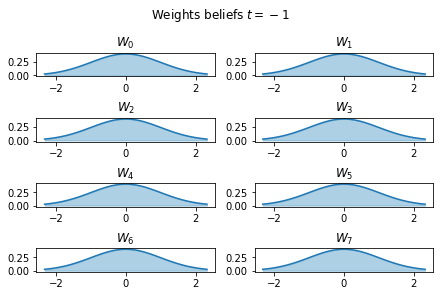

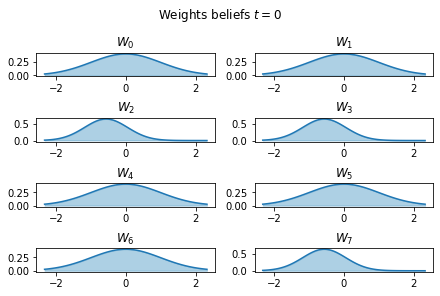

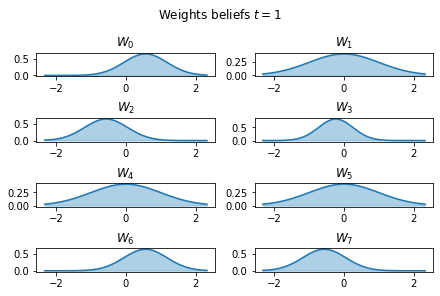

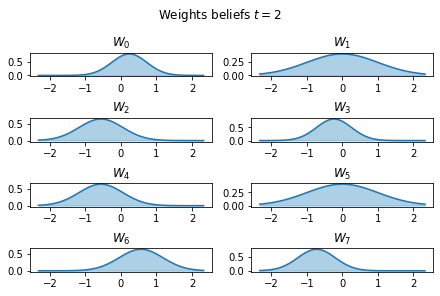

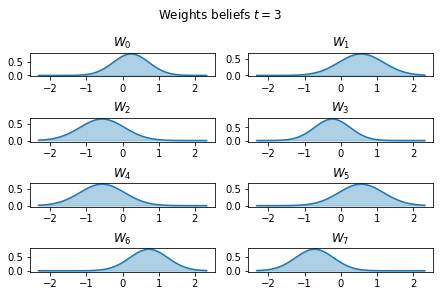

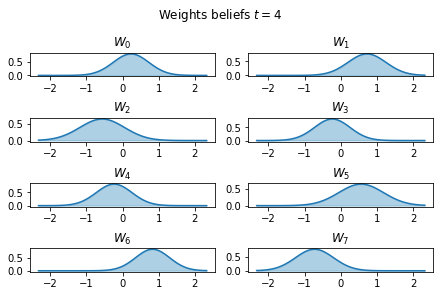

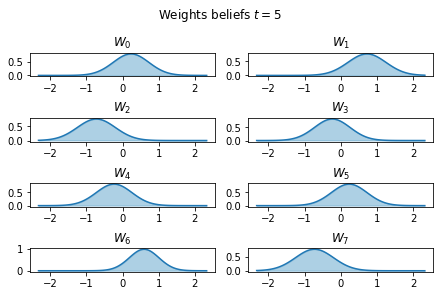

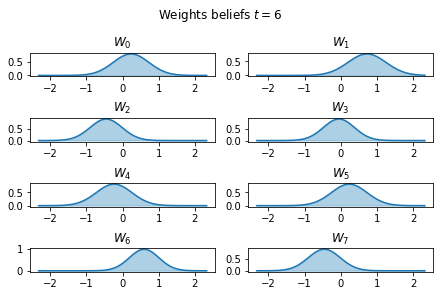

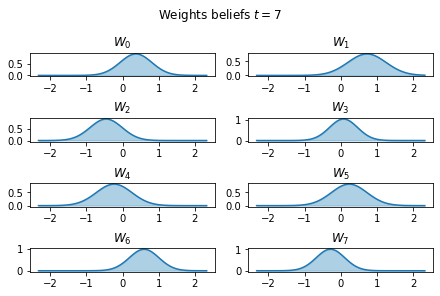

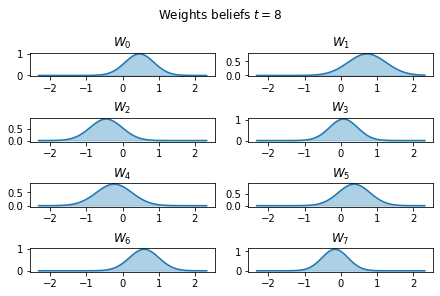

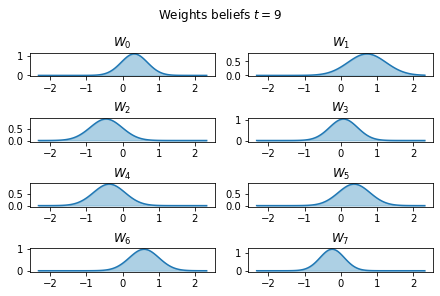

In [333]:
# time iterations
t = 10

mu = np.zeros(d)
sigma = np.ones(d)

plot_weights(mu, sigma, -1)

for i in range(t):
    row = df.iloc[i]
    feature = row['feature']
    reward = row['reward']
    
    mu, sigma = update(mu, sigma, feature, reward)
    
    plot_weights(mu, sigma, i)

## Thompson Sampling

solve $\arg \max_A B^T_{A, X} W$

- for all $t = 1, \ldots, T$ do
    - receive context $X_t$
    - sample $W_T$ from the posterior $P(W|H_{t-1})$
    - select $A_t = \arg \max_A B^T_{A, X_t} W_t$
    - display layout $A_t$ and observe reward $R_t$
    - update $H_t = H_{t-1} \cup (A_t, R_t, X_t)$

In [340]:
w_tilde = np.random.normal(mu, sigma)

b1 = feature_vector('top_rated', 'pricing', 'reviews')
b2 = feature_vector('top_rated', 'pricing', 'destination_guide')
b3 = feature_vector('suit_style', 'city_info', 'destination_guide')

c1 = np.sum(b1*w_tilde)
c2 = np.sum(b2*w_tilde)
c3 = np.sum(b3*w_tilde)

print(norm.cdf(c1))
print(norm.cdf(c2))
print(norm.cdf(c3))

norm.cdf([c1, c2])

0.35465279748469325
0.36724318593664107
0.7681202996291465


array([0.3546528 , 0.36724319])

In [131]:
df

,slot1,slot2,slot3,location_context,reward,feature
0,top_rated,weather,reviews,US,-1,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
1,suit_style,pricing,reviews,US,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
2,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
3,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...,...
995,map,pricing,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
996,map,pricing,reviews,US,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
997,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
998,top_rated,pricing,destination_guide,US,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]"


In [355]:
def search_space():
    b = itertools.product(choices_slot_1, choices_slot_2, choices_slot_3)
    c = [feature_vector(*x) for x in b]
    S = np.row_stack(c)
    print("Search space: \n {}".format(S))
    return S

def thompson_step(mu, sigma):

    # get context
    c = "US"
    
    # sample from the weights posterior
    w = np.random.normal(mu, sigma)
        
    # generate the search space
    S = search_space()
    
    # compute the posteriors for each
    s = np.sum(w * S, axis=1)
    s = norm.cdf(s)
    print("Probabilities of reward")
    print(s)

    # find the most likely layout
    best_index = np.argmin(s)
    best_layout = B[best_index]
    print(best_layout)
    describe_features(best_layout)
    
    #simulate and observe behavior
    
    
    mu, sigma = update(mu, sigma, best_layout, reward)
    
    plot_weights(mu, sigma, i)
    
    return mu, sigma
    
    

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[4.98128615e-01 1.06206733e-02 9.87062861e-01 4.71745628e-01
 2.53606497e-02 1.05554096e-05 7.02399994e-01 3.85588521e-02
 9.97145999e-01 6.79078702e-01 7.81211348e-02 1.00881148e-04
 6.11323723e-01 2.18892573e-02 9.94057747e-01 5.85731831e-01
 4.78200154e-02 3.66449922e-05]
[1. 0. 0. 0. 0. 1. 0. 1.]
suit_style
pricing
destination_guide


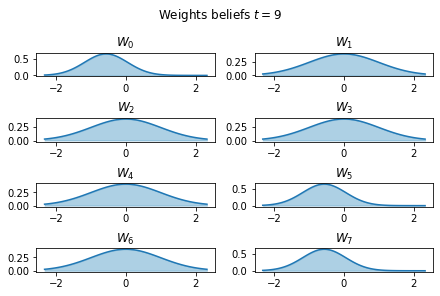

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.01130256 0.09123013 0.02758074 0.16582967 0.30059126 0.66426248
 0.23602092 0.59004643 0.36065081 0.72244003 0.85040727 0.97642815
 0.04059425 0.21272372 0.08357949 0.33193907 0.50539    0.83155702]
[1. 0. 0. 1. 0. 0. 1. 0.]
suit_style
city_info
reviews


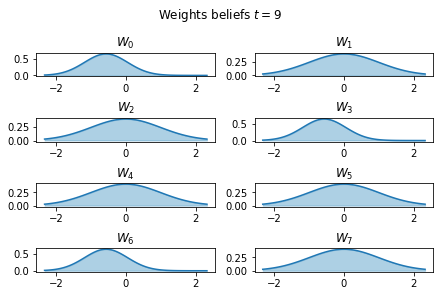

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[5.07062664e-01 9.37229429e-01 4.12873030e-03 1.29842194e-01
 3.33685004e-01 8.60919440e-01 2.48420755e-01 7.98071324e-01
 4.21115587e-04 3.40526400e-02 1.29885511e-01 6.50728237e-01
 9.82830855e-01 9.99858452e-01 2.93570078e-01 8.34284325e-01
 9.52402844e-01 9.99270788e-01]
[0. 1. 0. 0. 1. 0. 1. 0.]
map
weather
reviews


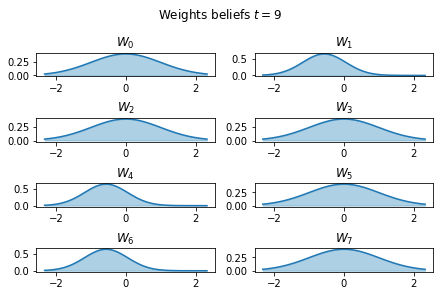

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.34394842 0.28092535 0.00679803 0.00407073 0.05458142 0.03750925
 0.60875417 0.53891058 0.03672871 0.0245132  0.17769553 0.13510764
 0.81481945 0.76344042 0.1209493  0.08872658 0.38038901 0.31460354]
[1. 0. 0. 0. 1. 0. 0. 1.]
suit_style
weather
destination_guide


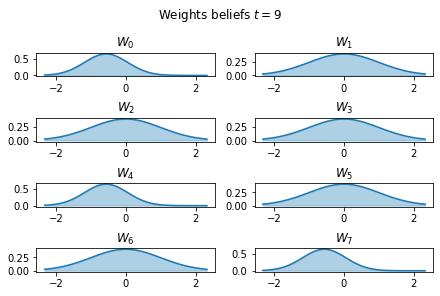

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.8777771  0.98606396 0.99106354 0.99966721 0.89947213 0.98965751
 0.42209912 0.79915578 0.84321706 0.97946902 0.46735397 0.82975889
 0.03127393 0.20404597 0.25523767 0.64692738 0.04025031 0.23803033]
[0. 0. 1. 1. 0. 0. 1. 0.]
top_rated
city_info
reviews


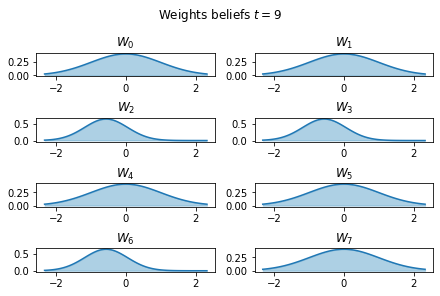

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[1.15123636e-01 8.45460759e-01 1.85816867e-03 2.46859110e-01
 2.09817700e-02 5.72600266e-01 7.50984686e-04 1.69176884e-01
 5.41657155e-07 3.91879263e-03 3.05577142e-05 3.65999372e-02
 2.15461712e-02 5.76937836e-01 9.78985359e-05 6.58414404e-02
 2.13850929e-03 2.61055885e-01]
[0. 1. 0. 0. 1. 0. 1. 0.]
map
weather
reviews


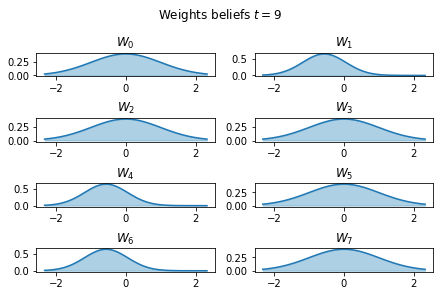

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[4.04608514e-01 9.08649657e-04 7.72969117e-01 1.66488690e-02
 9.06489926e-01 5.96534087e-02 1.08108288e-01 1.94610543e-05
 4.02626557e-01 8.92993118e-04 6.27118303e-01 5.34143523e-03
 9.49864704e-01 1.08677446e-01 9.95776251e-01 4.03810850e-01
 9.99323338e-01 6.28275620e-01]
[0. 1. 0. 1. 0. 0. 0. 1.]
map
city_info
destination_guide


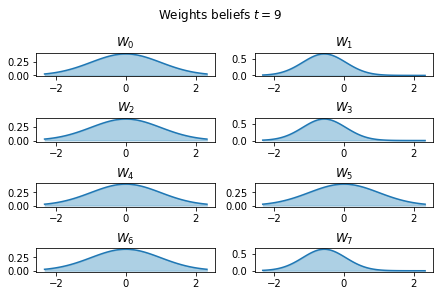

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.95496886 0.89250373 0.92393174 0.83569311 0.7365512  0.57049451
 0.70613849 0.53467336 0.60991398 0.43013878 0.30146846 0.16470638
 0.32649833 0.1828072  0.23803215 0.12145128 0.06527667 0.02458935]
[0. 0. 1. 0. 0. 1. 0. 1.]
top_rated
pricing
destination_guide


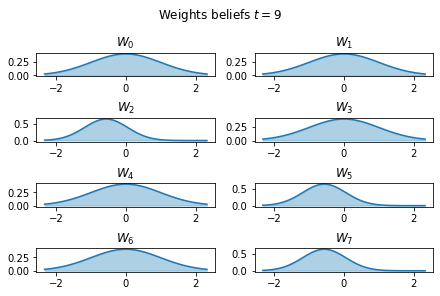

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.10096305 0.29598586 0.98190408 0.99770777 0.02327589 0.10560353
 0.23346907 0.50503946 0.99589584 0.99964213 0.07468755 0.24145188
 0.5778578  0.82549686 0.99981964 0.99999174 0.30227934 0.58793889]
[1. 0. 0. 0. 0. 1. 1. 0.]
suit_style
pricing
reviews


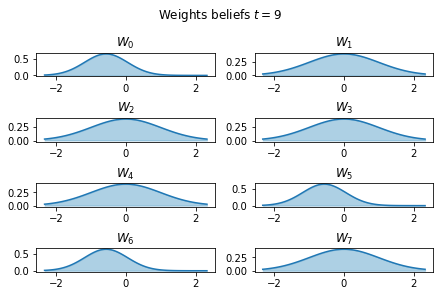

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probabilities of reward
[0.5576471  0.18275424 0.51939794 0.15834513 0.93157304 0.66919245
 0.22402052 0.0352558  0.19626207 0.02839173 0.72036228 0.32060524
 0.36538265 0.08165385 0.32979782 0.06805999 0.84098039 0.47949154]
[0. 1. 0. 0. 1. 0. 0. 1.]
map
weather
destination_guide


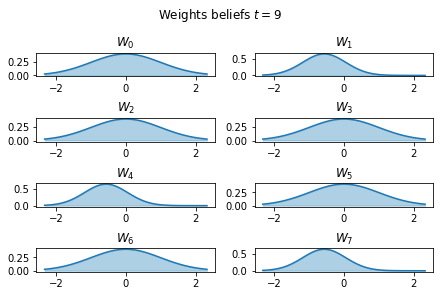

In [356]:
mu = np.zeros(d)
sigma = np.ones(d)

H = pd.DataFrame(columns=["slot1", "slot2", "slot3"])

for t in range(10):
    thompson_step(mu, sigma)